In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from matplotlib import gridspec

In [2]:
#tube = readsav('dat/f4.sav',verbose=True,python_dict=True)
tube = readsav('/Users/WilliamHenryAshfieldIV/spring2020/dat/f4.sav',verbose=False,python_dict=False)
frac = readsav('/Users/WilliamHenryAshfieldIV/spring2020/dat/f4_si_iv_nei.sav',verbose=False,python_dict=False)

In [3]:
log10T,log10G = np.loadtxt('/Users/WilliamHenryAshfieldIV/spring2020/dat/goft_1403.dat.txt',comments='%',unpack=True)

In [4]:
# set inital values
line = 1403.
mass = 28.0*1.66054e-27
kb = 1.3807e-23
c = 300
h = 6.62607e-27
flux=1.0e3 #? why this val?

In [5]:
ll = np.arange(line-10,line+10,0.01)

In [6]:
time= 55 # index = 0.1*time in seconds

In [7]:
t = tube.tarr.t[time]
n = tube.tarr.n[time]
los_v = tube.tarr.v[time].T[0]
sm_v = -savgol_filter(los_v,3,1)
los_x = tube.tarr.x[time].T[0]
n_e = tube.tarr.epamu[time]*tube.tarr.rho[time]/1.67e-8 # number density 
b = tube.tarr.b[time]
dl_e = tube.tarr.dl_e[time]

In [8]:
# interpolate our GofT data
te = 10**log10T
inter = interp1d(te,log10G,kind='cubic', bounds_error=False, fill_value=-10e6) #fill outide vals with large, small number
temp = 1e6*tube.tarr.t[time]
G = inter(temp)

In [9]:
G[temp<22000] = -10000 # set all log10G with low temp to large, small number (st 10^G~0)

In [10]:
f_nei=frac.fraq.f_nei[0]
f_nei = f_nei[:,time]
f_eqi=frac.fraq.f_eqi[0]
f_eqi = f_eqi[:,time]

In [11]:
np.set_printoptions(threshold=100)
jjjs = np.where(G > -5e1)
jjjs

(array([ 657,  658,  659,  660, 1353, 1354, 1355, 1356]),)

(array([291, 292, 293, ..., 912, 913, 914]),)


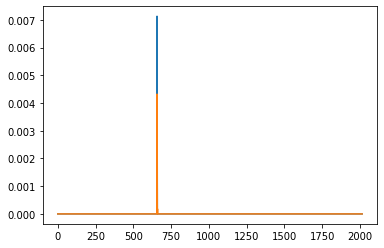

In [44]:
plt.plot(f_eqi)
plt.plot(f_nei)
#plt.ylim(0,0.00001)
f_jj = np.where(f_nei > 0)
print(f_jj)

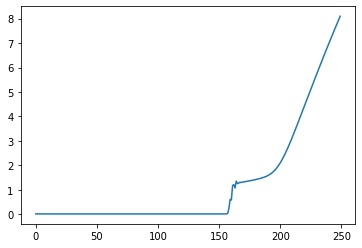

In [47]:
plt.plot(t[500:750])

In [13]:
# define subregion 
i_min,i_max = 285,720 # left half of tube (start = 3.9s)
#i_min,i_max = 1294,1715 # right half of tube

t_s = t[i_min:i_max]
n_s = len(t_s)
los_v_s = los_v[i_min:i_max]
sm_v_s = sm_v[i_min:i_max]
los_x_s = los_x[i_min:i_max]
n_e_s = n_e[i_min:i_max]
b_s = b[i_min:i_max]
dl_e_s = dl_e[i_min:i_max]
G_s = G[i_min:i_max]
f_nei_s = f_nei[i_min:i_max]
f_eqi_s = f_eqi[i_min:i_max]

In [14]:
# interpolate 
N=10*n_s
i_s = np.arange(0,n_s)
ii = np.arange(0,10*(n_s-1))*0.1

int_x = interp1d(i_s,los_x_s,kind='linear')#,fill_value="extrapolate")
int_v = interp1d(i_s,sm_v_s,kind='linear')
int_t = interp1d(i_s,t_s,kind='linear')
int_ne = interp1d(i_s,n_e_s,kind='linear')
int_b = interp1d(i_s,b_s,kind='linear')
int_dl_e = interp1d(i_s,dl_e_s,kind='linear')
int_G = interp1d(i_s,G_s,kind='linear')
int_fnei = interp1d(i_s,f_nei_s,kind='linear')
int_feqi = interp1d(i_s,f_eqi_s,kind='linear')

# new, interpolated arrays from tarr/tube
x = int_x(ii)
v = int_v(ii)
T = int_t(ii)
ne = int_ne(ii)
B = int_b(ii)
Dl = int_dl_e(ii)
g = int_G(ii)
nei = int_fnei(ii)
eqi = int_feqi(ii)

In [15]:
# process to create volume given per flux (per Maxwell)
rad=np.sqrt(flux/B/np.pi)
b_e=0.5*( np.roll(B, -1) + B )
A1=rad
A2=np.roll(rad,-1)
A2[(len(B))-1]=A2[len(B)-2]
volume=(1./3.)*Dl*(A1+A2+np.sqrt(A1*A2))*1e24
#calcualte emission measure EM
EM=volume*ne**2

In [16]:
sig = line*np.sqrt(kb*1e6*T/mass)/(c*1e6) # other thermal width 

In [17]:
factor = nei/eqi
np.nan_to_num(factor, copy=False, nan=1); # replace inf values with 1 (due to zeros in eqi)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(3700, 3760)

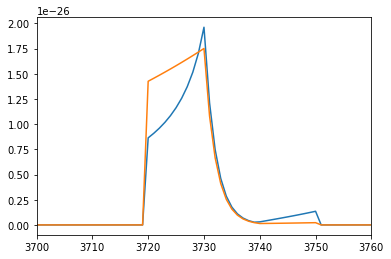

In [49]:
plt.plot(factor*10**g)
plt.plot(10**g)
plt.xlim(3700,3760)

In [50]:
T[3720]

0.04301484228395569

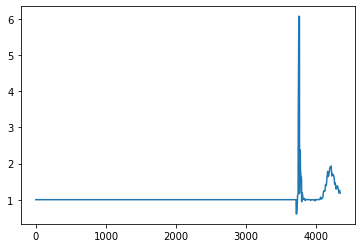

In [52]:
plt.plot(factor)

(3700, 3760)

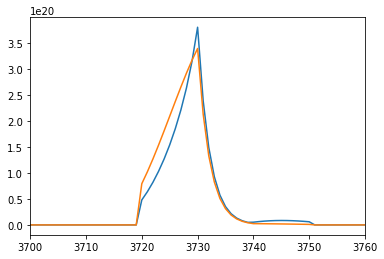

In [19]:
plt.plot(EM*factor*10**g)
plt.plot(EM*10**g)
plt.xlim(3700,3760)

In [20]:
nn=10*(n_s-1)
emissNEI = np.empty([nn,len(ll)])
emiss = emissNEI
for i in range(nn):
    emissNEI[i,:] = EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi*sig[i])*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))
    emiss[i,:] = EM[i]*10**g[i]/np.sqrt(2*np.pi*sig[i])*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))
    #emiss[i,:] = EM[i]*10**g[i]/np.sqrt(2*np.pi*sig[i])*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))
    #emiss2[i,:] = EM[i]*10**g[i]*line/(c*1e6)*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))

(3715, 3750)

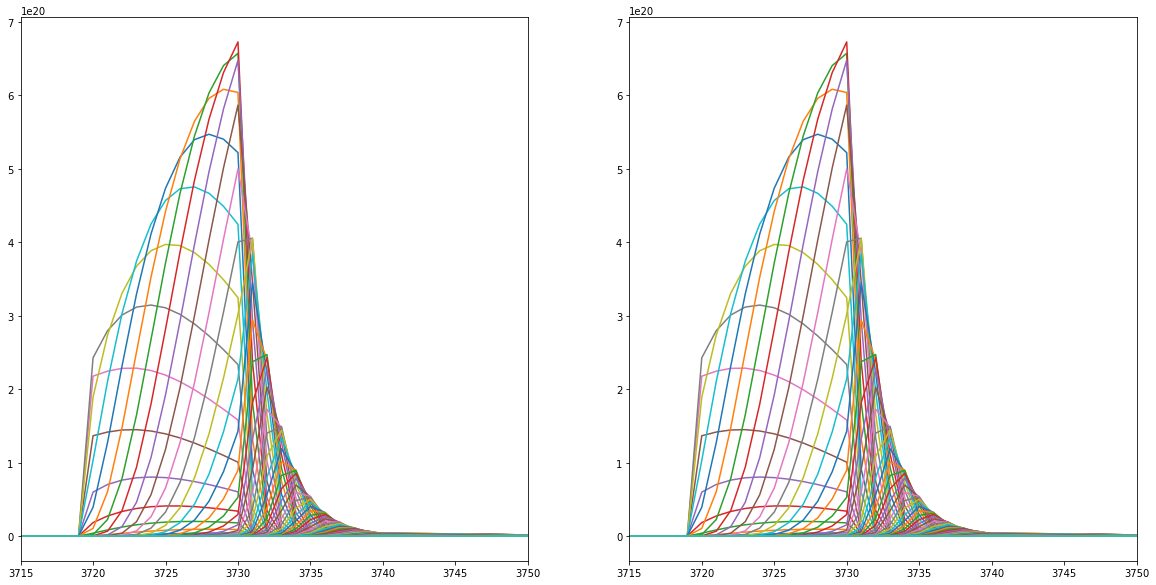

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(emissNEI);
plt.xlim(3715,3750)
plt.subplot(122)
plt.plot(emiss);
plt.xlim(3715,3750)

In [22]:
tot_emissNEI = np.sum(emissNEI,axis=0)
tot_emissNEI /= max(tot_emissNEI) #normalize
tot_emiss = np.sum(emiss,axis=0)
tot_emiss /= max(tot_emiss) #normalize

Text(0.5, 0, 'wavelength [$\\AA$]')

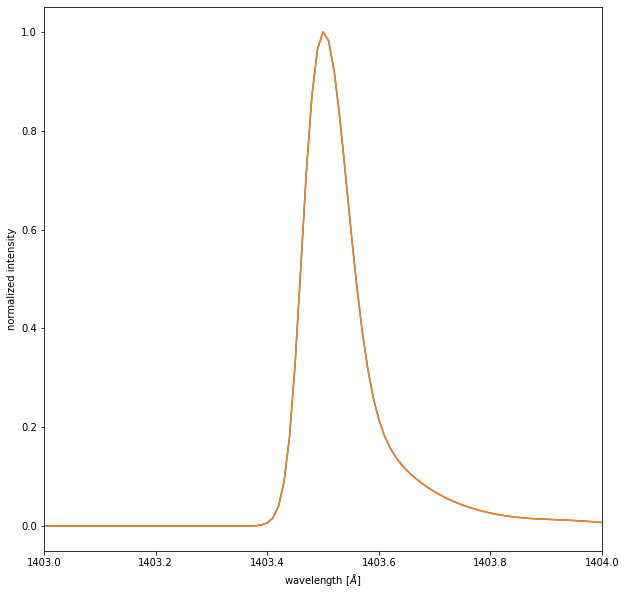

In [23]:
#fig=plt.figure(figsize=[10,10])
fig, ax = plt.subplots(figsize=[10,10])
plt.plot(ll,tot_emissNEI)
plt.plot(ll,tot_emiss)
plt.xlim(1403,1404)
plt.ylabel('normalized intensity')
ax.set_xlabel('wavelength [$\AA$]')

#fig.savefig('specI.png',bbox_inches='tight', dpi=600)

In [24]:
np.max(tot_emiss-tot_emissNEI)

0.0

(1403, 1404.5)

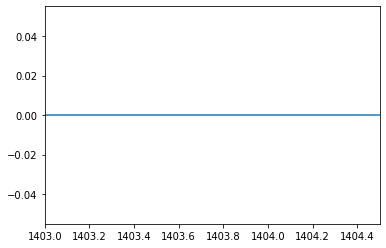

In [25]:
plt.plot(ll,tot_emiss-tot_emissNEI)
plt.xlim(1403,1404.5)

In [26]:
def oneGauss(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

In [27]:
#init params
amp1 = 0.6
sigma1 = 0.1
cen1 = 1404

In [28]:
popt_gauss, pcov_gauss = curve_fit(oneGauss, ll, tot_emiss, p0=[amp1, cen1, sigma1])
perr_gauss = np.sqrt(np.diag(pcov_gauss))

In [29]:
print("amplitude = %0.2f (+/-) %0.2f" % (popt_gauss[0], perr_gauss[0]))
print("center = %0.2f (+/-) %0.2f" % (popt_gauss[1], perr_gauss[1]))
print("sigma = %0.2f (+/-) %0.2f" % (popt_gauss[2], perr_gauss[2]))

amplitude = 0.98 (+/-) 0.00
center = 1403.51 (+/-) 0.00
sigma = 0.04 (+/-) 0.00


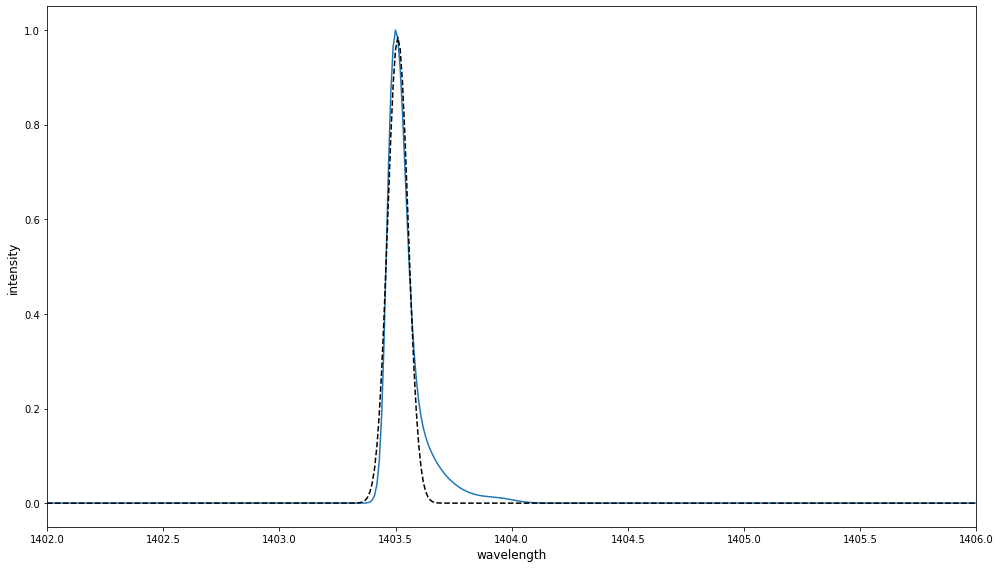

In [30]:
#plot
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(ll, tot_emiss)
ax1.plot(ll, oneGauss(ll, *popt_gauss), 'k--')#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

plt.xlim(1402,1406)

ax1.set_xlabel("wavelength",  fontsize=12)
ax1.set_ylabel("intensity",  fontsize=12)


fig.tight_layout()

In [31]:
def twoGauss(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

amplitude = 0.19 (+/-) 0.00
center = 1403.59 (+/-) 0.00
sigma = -0.07 (+/-) 0.00
amplitude = 0.93 (+/-) 0.01
center = 1403.50 (+/-) 0.00
sigma = 0.04 (+/-) 0.00


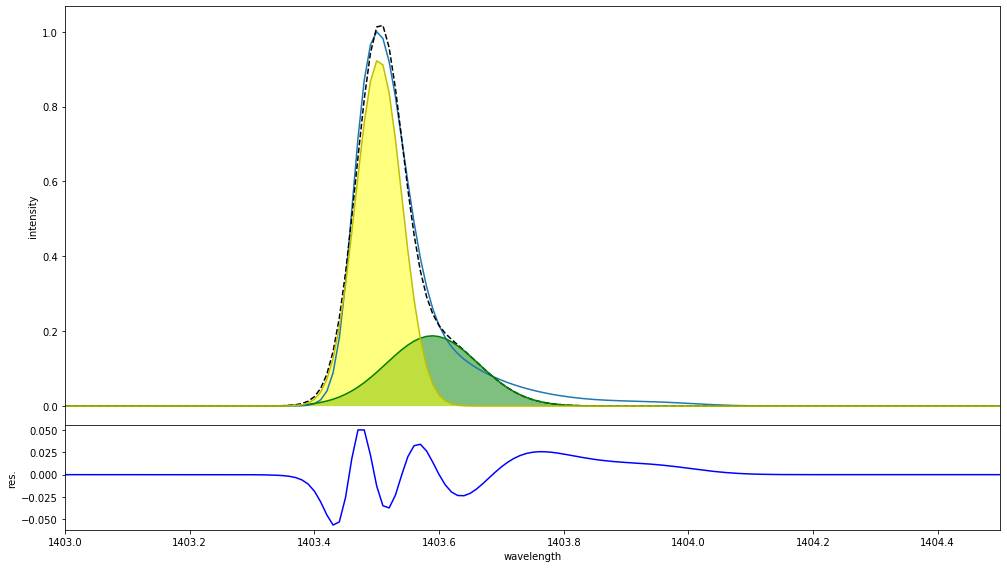

In [32]:
amp2 = 0.6
sigma2 = 0.01
cen2 = 1404
popt_2gauss, pcov_2gauss = curve_fit(twoGauss, ll, tot_emiss, \
                                                    p0=[amp1, cen1, sigma1, amp2, cen2, sigma2], maxfev=4000)
perr_2gauss = np.sqrt(np.diag(pcov_2gauss))
print("amplitude = %0.2f (+/-) %0.2f" % (popt_2gauss[0], perr_2gauss[0]))
print("center = %0.2f (+/-) %0.2f" % (popt_2gauss[1], perr_2gauss[1]))
print("sigma = %0.2f (+/-) %0.2f" % (popt_2gauss[2], perr_2gauss[2]))
print("amplitude = %0.2f (+/-) %0.2f" % (popt_2gauss[3], perr_2gauss[3]))
print("center = %0.2f (+/-) %0.2f" % (popt_2gauss[4], perr_2gauss[4]))
print("sigma = %0.2f (+/-) %0.2f" % (popt_2gauss[5], perr_2gauss[5]))

pars_1 = popt_2gauss[0:3]
pars_2 = popt_2gauss[3:6]
gauss_peak_1 = oneGauss(ll, *pars_1)
gauss_peak_2 = oneGauss(ll, *pars_2)
residual_2gauss = tot_emiss - (twoGauss(ll, *popt_2gauss))


#plot
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2,1, height_ratios=[1,0.25])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
gs.update(hspace=0) 

ax1.plot(ll, tot_emiss)
ax1.plot(ll, twoGauss(ll, *popt_2gauss), 'k--')#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

# peak 1
ax1.plot(ll, gauss_peak_1, "g")
ax1.fill_between(ll, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)
  
# peak 2
ax1.plot(ll, gauss_peak_2, "y")
ax1.fill_between(ll, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)  
ax1.get_xaxis().set_visible(False)

# residual
ax2.plot(ll, residual_2gauss, "b")
    
ax1.set_xlim(1403,1404.5)
ax2.set_xlim(1403,1404.5)

ax2.set_xlabel("wavelength")
ax1.set_ylabel("intensity")
ax2.set_ylabel("res.")

fig.tight_layout()
#fig.savefig("fit2Gaussian_peaks_resid.png", format="png",dpi=1000)

In [33]:
# trim excess zeros in data
jj = np.where((ll > 1403) & (ll < 1405))
ll = ll[jj]
tot_emiss = tot_emiss[jj]

y_model = twoGauss(ll, *popt_2gauss)
y = tot_emiss
error = 0.001

chi2 = ((y_model - y) / error)**2

x2=np.sum(chi2)

rx2 = x2/(len(tot_emiss)-6)
print(rx2)

181.0913706740429


In [34]:
# single Gaussian
y_model=oneGauss(ll, *popt_gauss)
chi2 = ((y_model - y) / error)**2
x2=np.sum(chi2)
rx2 = x2/(len(tot_emiss)-3)
print(rx2)

1043.1760884823836


In [35]:
def threeGauss(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2))) + \
            amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))

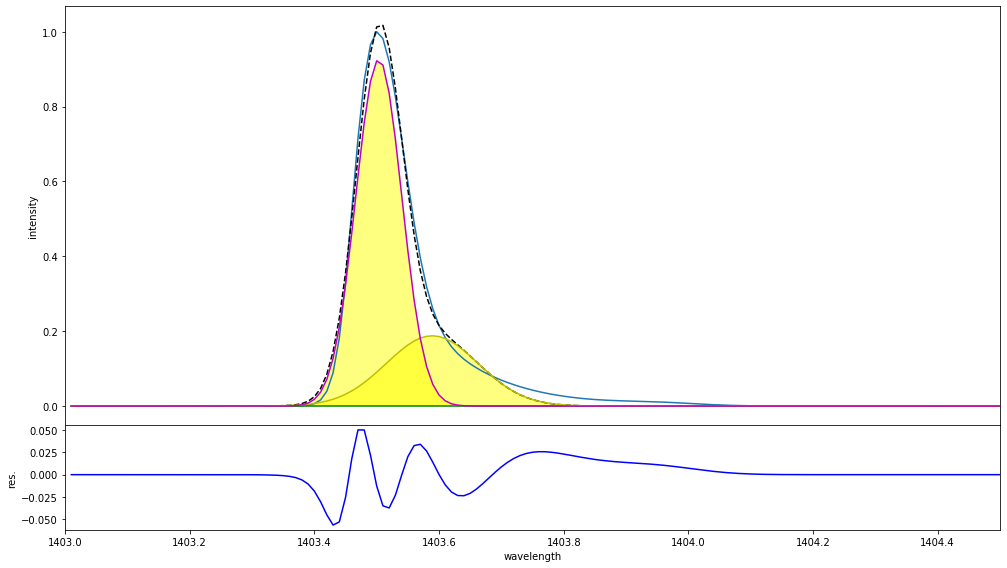

In [36]:
amp3 = 0.5
sigma3 = 0.01
cen3 = 1403.5
popt_3gauss, pcov_3gauss = curve_fit(threeGauss, ll, tot_emiss, \
                                    p0=[amp1, cen1, sigma1, amp2, cen2, sigma2,amp3,cen3,sigma3], maxfev=4000)
perr_3gauss = np.sqrt(np.diag(pcov_2gauss))

pars_1 = popt_3gauss[0:3]
pars_2 = popt_3gauss[3:6]
pars_3 = popt_3gauss[6:9]
gauss_peak_1 = oneGauss(ll, *pars_1)
gauss_peak_2 = oneGauss(ll, *pars_2)
gauss_peak_3 = oneGauss(ll, *pars_3)
residual_3gauss = tot_emiss - (threeGauss(ll, *popt_3gauss))


#plot
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2,1, height_ratios=[1,0.25])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
gs.update(hspace=0) 

ax1.plot(ll, tot_emiss)
ax1.plot(ll, threeGauss(ll, *popt_3gauss), 'k--')#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

# peak 1
ax1.plot(ll, gauss_peak_1, "g")
ax1.fill_between(ll, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)
  
# peak 2
ax1.plot(ll, gauss_peak_2, "y")
ax1.fill_between(ll, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)  

# peak 3
ax1.plot(ll, gauss_peak_3, "m")
ax1.fill_between(ll, gauss_peak_2.min(), gauss_peak_3, facecolor="yellow", alpha=0.5)  
ax1.get_xaxis().set_visible(False)

# residual
ax2.plot(ll, residual_3gauss, "b")
    
ax1.set_xlim(1403,1404.5)
ax2.set_xlim(1403,1404.5)

ax2.set_xlabel("wavelength")
ax1.set_ylabel("intensity")
ax2.set_ylabel("res.")

fig.tight_layout()
#fig.savefig("fit2Gaussian_peaks_resid.png", format="png",dpi=1000)

In [37]:
# triple Gaussian
y_model=threeGauss(ll, *popt_3gauss)
chi2 = ((y_model - y) / error)**2
x2=np.sum(chi2)
rx2 = x2/(len(tot_emiss)-6)
print(rx2)

181.0912116266075


In [38]:
perr_3gauss

array([0.00449442, 0.00402508, 0.00210178, 0.01107912, 0.00013307,
       0.00026093])

In [39]:
(1403.88 -line)/line*3e5

188.1682109765023